# Hamiltonian NN (HNN) in (q, v) space

- Original code for (q, v) space from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target_ms_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input_ms_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l4 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l4(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
import time
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mynet = MLP(input_size,hidden_size,output_size).to(device)
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=mynet.parameters(),lr=1e-4)

  history_loss = []
  history_eval = []
  history_acc = []

  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    mynet.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mynet.grad(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    mynet.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mynet.grad(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/danieljh_hnn_ms_sep_sc_2t_lr_{}".format(trial)
      torch.save(mynet.state_dict(), path)
  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))


2000/2000 training loss:8.002200074770371e-05,evaluation loss:7.834390089556109e-05
2000/2000 training loss:7.964925380292698e-05,evaluation loss:7.842302402423229e-05
2000/2000 training loss:7.953634212753968e-05,evaluation loss:7.89829449786339e-05
2000/2000 training loss:7.988370662133093e-05,evaluation loss:7.832271621737164e-05
2000/2000 training loss:8.008189815882361e-05,evaluation loss:7.880877201387193e-05
2000/2000 training loss:7.94526804384077e-05,evaluation loss:8.005137206055224e-05
2000/2000 training loss:7.958264359331224e-05,evaluation loss:8.127571854856796e-05
2000/2000 training loss:8.072020827967207e-05,evaluation loss:8.006363568711095e-05
2000/2000 training loss:7.924452465886133e-05,evaluation loss:7.851422160456422e-05
2000/2000 training loss:7.971950944920536e-05,evaluation loss:7.903658515715506e-05
train_loss:7.978927678777836e-05, std: 3.945297537541148e-07
test_loss:7.918228911876212e-05, std: 9.262593881850819e-07
computation_time:816.0682372331619, std: 

In [6]:
import pandas as pd
A = pd.read_csv("./data/A_ms_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_ms_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


/tmp/ipykernel_203460/3086021536.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_203460/3086021536.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


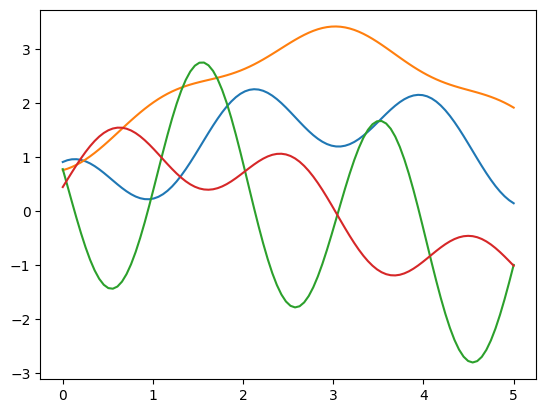

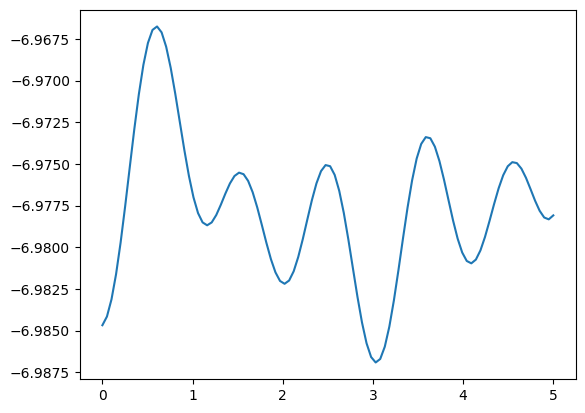

In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

trial = num_trials - 1

input_size = 4
output_size = 1
hidden_size = 200
mynet = MLP(input_size,hidden_size,output_size).to('cpu')
mynet.load_state_dict(torch.load("./model/danieljh_hnn_ms_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
mynet.eval()

teval = torch.linspace(0.0,5.0,100)

# initial value (q1, q2, v1, v2 order)
x0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)

print(x0)
dt = teval[1]-teval[0]
St = torch.tensor(-S, dtype=torch.float32)
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()

def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

ax=plt.subplot()
# ax.set_ylim([-3,3])
ax.plot(teval,res[:,0])
ax.plot(teval,res[:,1])
ax.plot(teval,res[:,2])
ax.plot(teval,res[:,3])
  
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
   
q1 = res[:, 0]
q2 = res[:, 1]
v1 = res[:, 2]
v2 = res[:, 3]

hnn_x = res.copy()  # (M, 4) [q1, q2, v1, v2]


In [ ]:
def Hamiltonian_qv(orbits_qv):
    """
    Computes the total energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, v1, v2)
    """
    q1 = orbits_qv[:,0]
    q2 = orbits_qv[:,1]
    v1 = orbits_qv[:,2]
    v2 = orbits_qv[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

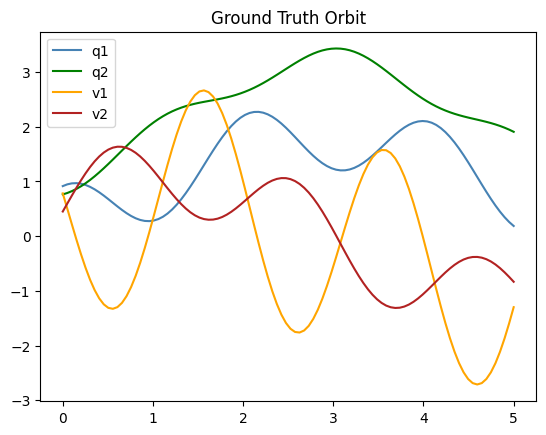

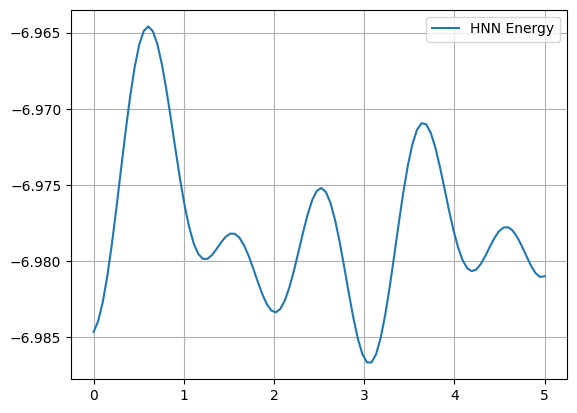

In [ ]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)
x0 = state[0]

sol = solver(func, [0, tend], x0, t_eval=t_eval)

tval = sol['t']
true_x = sol['y'].T # (M, 4) [q1, q2, v1, v2]

ax=plt.subplot()
ax.plot(tval, true_x[:, 0], 'steelblue', label='q1')
ax.plot(tval, true_x[:, 1], 'g', label='q2')
ax.plot(tval, true_x[:, 2], 'orange', label='v1')
ax.plot(tval, true_x[:, 3], 'firebrick', label='v2')
ax.legend()
plt.title("Ground Truth Orbit")
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

hnn_energy_true_x = net_energy(true_x, teval).reshape((100))
plt.plot(tval, hnn_energy_true_x, label='HNN Energy')
plt.legend()
plt.grid(True)
plt.show()

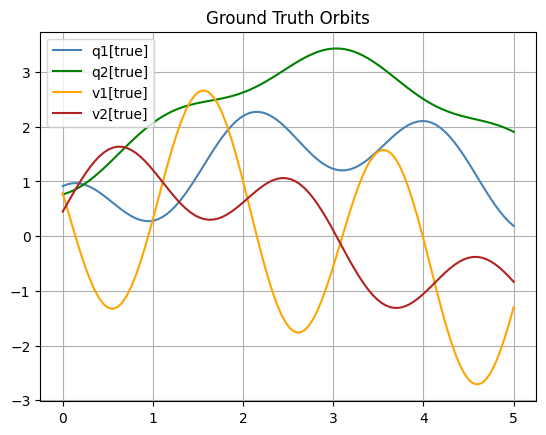

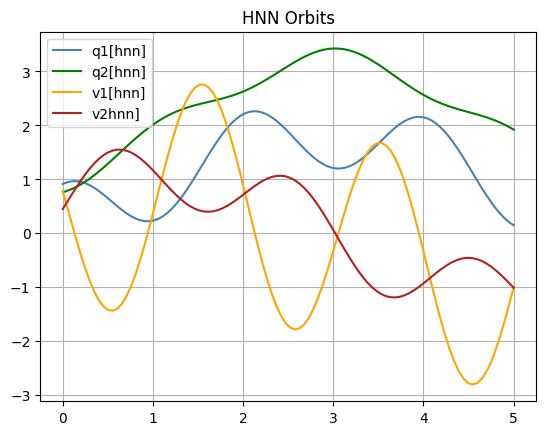

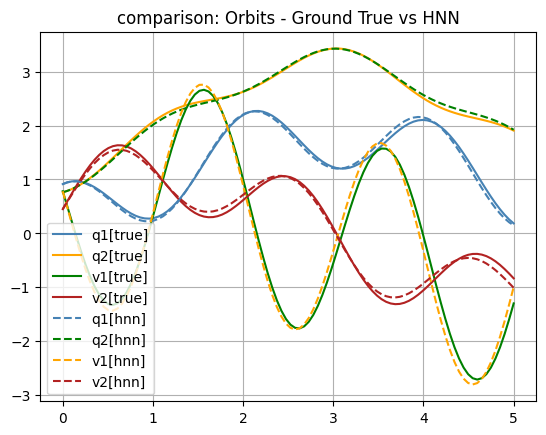

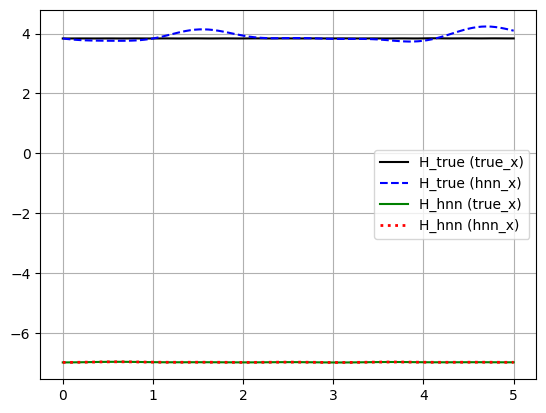

In [13]:
plt.title("Ground Truth Orbits")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("HNN Orbits")
plt.plot(tval, hnn_x[:,0], 'steelblue', label='q1[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,1], 'g', label='q2[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,2], 'orange', label='v1[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,3], 'firebrick', label='v2hnn]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs HNN")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, hnn_x[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,1], 'g', label='q2[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,2], 'orange', label='v1[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,3], 'firebrick', label='v2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

hnn_energy_hnn_x = net_energy(hnn_x, teval).reshape((100))
hnn_energy_true_x = net_energy(true_x, teval).reshape((100))
true_energy_hnn_x = Hamiltonian_qv(hnn_x)
true_energy_true_x = Hamiltonian_qv(true_x)

plt.plot(teval,true_energy_true_x, label='H_true (true_x)', color='k', linestyle='-')
plt.plot(teval,true_energy_hnn_x, label='H_true (hnn_x)', color='b',linestyle='--')
plt.plot(teval,hnn_energy_true_x, label='H_hnn (true_x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval,hnn_energy_true_x, label='H_hnn (hnn_x)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()